#<b>Supervised learning: using XGBoost (eXtreme Gradient Boosting) for predicting a phenotype/variable of interest</b><br>

Author: Francesco Russo, frru@ssi.dk<br>
Last Update: July 29, 2022<br>

Notebook for the International Summer School on non-targeted metabolomics 2022.<br>

In this notebook, we are going to use a supervised machine learning model to predict a variable of interest. <b>It's important to keep in mind that in the following example we have few samples, therefore the predictions have to be used as "toy example". Ideally, you would like many more samples and a meaningful prediction to perform (and not a trivial one!).</b><br>

We use XGBoost, which stands for Extreme Gradient Boosting, a scalable, distributed gradient-boosted decision tree (GBDT) machine learning library which is implemented in many programming languages. Currently, XGBooost is the leading machine learning library for different learning tasks such as regression and classification and it usually wins several data science competitions for analysing tabular data.<br>

Some useful info at:<br>
XGBoost: https://xgboost.readthedocs.io/en/stable/R-package/xgboostPresentation.html (R package for training an XGBoost model)
Caret: https://topepo.github.io/caret/ (R package for training different machine learning models).

In [1]:
# last update
Sys.time()

[1] "2022-07-29 13:34:39 UTC"

In [2]:
install.packages("xgboost")
install.packages("caret")
install.packages("dplyr")
install.packages("pROC")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [3]:
library("xgboost")
library("caret")
library("dplyr")
library("pROC")

Loading required package: ggplot2

Loading required package: lattice

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”

Attaching package: ‘dplyr’


The following object is masked from ‘package:xgboost’:

    slice


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:stats’:

    cov, smooth, var




<b>Importing feature table and metadata</b><br>

In the following, we import the cleaned and imputed feature table (performed by Abzer, GitHub: @abzer005).

In [4]:
# Here, we import the files from GitHub but you can import them from your local computer or from Google Drive as well of course
# cleaned and imputed (but not normalized feature table)
ft_url <- 'https://raw.githubusercontent.com/Functional-Metabolomics-Lab/Summer-School_Functional-Metabolomics/main/MZmine%20Files_Results_Generated_using_JupyterNotebook/Imputed_QuantTable_with_MinValue_3766_Full.csv'
# metadata
md_url <- 'https://raw.githubusercontent.com/Functional-Metabolomics-Lab/Summer-School_Functional-Metabolomics/main/MZmine%20Files/20220726_Xenobiotic_Metabolism_metadata.txt'

In [5]:
ft <- read.csv(ft_url, header = T, check.names = F, row.names = 1)
md <- read.csv(md_url, header = T, check.names = F, sep = '\t')

In [6]:
dim(ft)
dim(md)

[1] 5759   80

[1] 82  7

In [7]:
head(ft, n = 2)

,t2_Ec_C.mzML,t2_BS_C.mzML,t1_BS_C.mzML,t0_BS_C.mzML,t0_Ec_C.mzML,t1_Ec_C.mzML,t0_Ec_3.mzML,t0_Ec_1.mzML,t1_BS_3.mzML,t1_BS_1.mzML,⋯,t9_Ec_C.mzML,t9_Ec_1.mzML,t8_Ec_1.mzML,t9_Ec_3.mzML,t8_BS_C.mzML,t9_Ec_2.mzML,t9_BS_C.mzML,t9_BS_3.mzML,t9_BS_1.mzML,t9_BS_2.mzML
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
48_284.049_0.296,57190.83,30703.12,22455.54,16610.77,12647.69,45817.29,36945.29,7563.947,127769.73,45541.16,⋯,68534.04,62049.73,68566.64,69222.69,59887.89,56783.34,63848.29,38388.64,69037.84,158943.36
97_245.095_0.521,3766.00,3766.00,3766.00,3766.00,3766.00,3766.00,63810.39,105098.740,39515.62,74559.23,⋯,31211.48,24871.02,35276.88,35860.07,43292.93,36117.34,33443.48,34075.53,34425.60,51332.15


In [8]:
# number of NAs (which are reported here as 3766)
(sum(ft == '3766')*100)/(dim(ft)[1]*dim(ft)[2])

[1] 50.62945

In [9]:
head(md, n = 2)

,filename,ATTRIBUTE_species,ATTRIBUTE_SampleType,ATTRIBUTE_timepoint,ATTRIBUTE_hours,ATTRIBUTE_mins,ATTRIBUTE_replicates
,<chr>,<chr>,<chr>,<int>,<dbl>,<int>,<int>
1,t0_BS_1.mzML Peak area,B.subtilis,With_Treatment,0,-0.1666667,-10,1
2,t0_BS_2.mzML Peak area,B.subtilis,With_Treatment,0,-0.1666667,-10,2


<b>Bring featuretable and metadata in the correct format:</b><br>

- Get rid of 'Peak area' extension in filenames to match with metadata and transform metadata rownames to filenames, transform featuretable rownames to a unique identifier consisting of feature IDs, m/z and RT
- Remove NA columns from metadata.

In [10]:
# clean column names of feature table and metadata
md$filename <- gsub(' Peak area','',md$filename)
# keep only columns in metadata without NAs
md <- md[,1:7]
rownames(md) <- md$filename

In [11]:
head(md, n= 2)

,filename,ATTRIBUTE_species,ATTRIBUTE_SampleType,ATTRIBUTE_timepoint,ATTRIBUTE_hours,ATTRIBUTE_mins,ATTRIBUTE_replicates
,<chr>,<chr>,<chr>,<int>,<dbl>,<int>,<int>
t0_BS_1.mzML,t0_BS_1.mzML,B.subtilis,With_Treatment,0,-0.1666667,-10,1
t0_BS_2.mzML,t0_BS_2.mzML,B.subtilis,With_Treatment,0,-0.1666667,-10,2


In [12]:
table(rownames(md) %in% colnames(ft))


FALSE  TRUE 
    2    80 

In [13]:
# the blanks are the only files not present in ft
setdiff(rownames(md),colnames(ft))

[1] "Blank_A.mzML" "Blank_B.mzML"

In [14]:
# filter out the blank samples from md
md <- md[rownames(md) %in% colnames(ft),]

In [15]:
dim(md)

[1] 80  7

In [16]:
# convert Specie into binary values
md$specie <- ifelse(md$ATTRIBUTE_species == 'E.coli', 1, 0)
# convert sample type into binary values
md$sample_class <- ifelse(md$ATTRIBUTE_SampleType == 'With_Treatment', 1, 0)

In [17]:
head(md, n=2)

,filename,ATTRIBUTE_species,ATTRIBUTE_SampleType,ATTRIBUTE_timepoint,ATTRIBUTE_hours,ATTRIBUTE_mins,ATTRIBUTE_replicates,specie,sample_class
,<chr>,<chr>,<chr>,<int>,<dbl>,<int>,<int>,<dbl>,<dbl>
t0_BS_1.mzML,t0_BS_1.mzML,B.subtilis,With_Treatment,0,-0.1666667,-10,1,0,1
t0_BS_2.mzML,t0_BS_2.mzML,B.subtilis,With_Treatment,0,-0.1666667,-10,2,0,1


In [18]:
# transpose ft
ft <- t(ft)

In [19]:
head(ft, n=2)

,48_284.049_0.296,97_245.095_0.521,105_181.097_0.521,108_157.097_0.52,113_166.103_0.533,114_160.076_0.522,120_169.097_0.525,128_318.184_0.528,132_166.086_0.53,134_228.121_0.534,⋯,12354_387.733_8.206,12355_214.918_8.214,12356_230.89_8.216,12357_248.9_8.216,12361_304.894_8.146,12386_245.128_8.986,12440_161.082_9.725,12447_179.093_9.788,12450_261.123_9.888,12453_261.123_9.91
t2_Ec_C.mzML,57190.83,3766,3766,3766,3766,3766,3766,3766,3766,3766,⋯,3766,27512.27,96410.06,44757.77,38627.54,62094.82,606578.4,608501.2,86233.76,35417.67
t2_BS_C.mzML,30703.12,3766,3766,3766,3766,3766,3766,3766,3766,3766,⋯,3766,24718.62,96060.30,45181.07,47485.14,50183.21,601207.0,606486.2,74582.01,63652.69


In [20]:
# make the rows in ft and md in the same order
ft <- ft[match(rownames(md),rownames(ft)),]

In [21]:
identical(rownames(md),rownames(ft))

[1] TRUE

In [22]:
# function to remove features having zero median absolute deviation (MAD) which affects the downstream analysis and make the computation slower
removeZeroVar <- function(df){
  df[, sapply(df, mad) != 0]
}

In [23]:
# number of features after removing zero-variance columns
dim(removeZeroVar(as.data.frame(ft)))[2]

[1] 2681

In [24]:
# apply the function
ft_mad <- removeZeroVar(as.data.frame(ft))

In [25]:
dim(ft_mad)

[1]   80 2681

In [26]:
# number of features with zero variance that have been removed
dim(ft)[2]-dim(ft_mad)[2]

[1] 3078

In [27]:
# center and scale data
ft_mad <- scale(ft_mad, center = T, scale = T)

###<b>Predicting variables of interest using XGBoost: specie (E.coli vs B.subtilis) and samples type (with_treatment vs without_treatment)

In [28]:
df_ft <- cbind(ft_mad,md[,colnames(md) %in% c('specie','sample_class')])

In [29]:
head(df_ft)

,48_284.049_0.296,97_245.095_0.521,105_181.097_0.521,108_157.097_0.52,114_160.076_0.522,120_169.097_0.525,128_318.184_0.528,132_166.086_0.53,135_167.082_0.549,137_176.093_0.531,⋯,12356_230.89_8.216,12357_248.9_8.216,12361_304.894_8.146,12386_245.128_8.986,12440_161.082_9.725,12447_179.093_9.788,12450_261.123_9.888,12453_261.123_9.91,specie,sample_class
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
t0_BS_1.mzML,-0.6168322,4.0956043,3.8650103,-0.003362348,0.006553771,0.53553422,4.372654,-0.1396324,-0.418012795,0.1581816,⋯,-2.565059,-2.252947,-2.1589838,-1.8525635,0.13065179,-2.566046,-1.19292385,-1.10238102,0,1
t0_BS_2.mzML,-0.3747503,0.7574282,0.7752285,-0.900048251,-0.590212212,-0.29088181,1.128212,-0.4776738,0.000651775,-0.7993604,⋯,-2.420095,-2.469295,-2.1589838,-1.3388755,0.31907776,-2.589249,-0.58186227,-1.05233257,0,1
t0_BS_3.mzML,-0.7325215,1.8904446,1.9986529,-0.730500429,-0.648525149,0.09243916,2.455633,-0.3928906,0.040081473,-0.2613945,⋯,-2.263430,-2.446386,-0.8708073,-1.1564185,-0.07058729,-2.505116,-0.60834943,-1.36187909,0,1
t0_BS_C.mzML,-1.0288643,-1.5535295,-1.6682436,-0.900048251,-1.549008396,-2.62385333,-1.304320,-1.3950675,-2.800795535,-2.1139146,⋯,-2.086352,-2.613392,-0.8612362,-2.5612446,1.15904264,-2.505059,-0.59936106,-1.61320556,0,0
t0_Ec_1.mzML,-1.2583890,1.8231409,1.6999582,0.229365477,-0.382085983,0.29955390,2.196443,-0.1489465,-0.907073219,0.3809616,⋯,-2.314209,-2.705907,-1.4637296,-1.1494103,0.77905327,-2.447650,-0.30012755,-1.95319669,1,1
t0_Ec_2.mzML,-1.0415979,3.0657557,3.0280019,1.055251187,0.038978517,0.88318882,3.649432,-0.2735918,-0.676069975,1.0314033,⋯,-2.081827,-1.694283,-1.1234631,-0.8641662,0.74387266,-2.444769,-0.08682396,-0.05899818,1,1


We start by predicting the specie. The first step is to split our data in a train and test set. The train, as the name itself refers to, will be used to train the model and learn which features are the most important in the model for predicting the specie. The test set is kept away from the training phase and is going to be used for evaluating the model performance.<br>

70% of the input data will be used for training the model and 30% for the test set (if we had more data, 80%-20% would be preferred).

In [30]:
# Split in train and test sets
# Set random seed to make results reproducible
set.seed(1234)
trainIndex <- caret::createDataPartition(df_ft$specie, p = 0.7, 
                                  list = FALSE, 
                                  times = 1)

ftTrain <- df_ft[trainIndex,]
ftTest  <- df_ft[-trainIndex,]

dim(ftTrain)
dim(ftTest)

[1]   56 2683

[1]   24 2683

In [31]:
table(ftTrain$specie)
table(ftTest$specie)


 0  1 
28 28 


 0  1 
12 12 

In [32]:
# format inputs for the next steps
train_x <- ftTrain[,1:ncol(ft_mad)]
train_y <- as.factor(ftTrain$specie)
test_x <- ftTest[,1:ncol(ft_mad)]
test_y <- as.factor(ftTest$specie)

In [33]:
dim(train_x)
table(train_y)
dim(test_x)
table(test_y)

[1]   56 2681

train_y
 0  1 
28 28 

[1]   24 2681

test_y
 0  1 
12 12 

First, we perform the analysis without tuning the parameters, by using default/recommended parameters.

In [34]:
# set default/recommended parameters for XGBoost
grid_default <- expand.grid(
  nrounds = 500,
  max_depth = 6,
  eta = 0.3,
  gamma = 0,
  colsample_bytree = 1,
  min_child_weight = 1,
  subsample = 1
)

# this function tells how the trian will be performed (in this case we do not apply any tuning of the parameters)
train_control <- caret::trainControl(
  method = "none",
  verboseIter = FALSE,
  allowParallel = FALSE # FALSE for reproducible results 
)

# perform the actual training
set.seed(1234)
xgb_base <- caret::train(
  x = train_x, y = train_y,
  trControl = train_control,
  tuneGrid = grid_default,
  method = "xgbTree",
  verbose = TRUE
)

In [35]:
xgb_base

eXtreme Gradient Boosting 

  56 samples
2681 predictors
   2 classes: '0', '1' 

No pre-processing
Resampling: None 

In [36]:
# We now predict on test data
predicted_base <- predict(xgb_base, test_x)
# evaluate performance
confusionMatrix(data = predicted_base, reference = test_y, positive = '1', mode = 'everything')

Confusion Matrix and Statistics

          Reference
Prediction  0  1
         0 11  0
         1  1 12
                                          
               Accuracy : 0.9583          
                 95% CI : (0.7888, 0.9989)
    No Information Rate : 0.5             
    P-Value [Acc > NIR] : 1.49e-06        
                                          
                  Kappa : 0.9167          
                                          
 Mcnemar's Test P-Value : 1               
                                          
            Sensitivity : 1.0000          
            Specificity : 0.9167          
         Pos Pred Value : 0.9231          
         Neg Pred Value : 1.0000          
              Precision : 0.9231          
                 Recall : 1.0000          
                     F1 : 0.9600          
             Prevalence : 0.5000          
         Detection Rate : 0.5000          
   Detection Prevalence : 0.5417          
      Balanced Accuracy : 0.9583    

In [37]:
# predict on test data (this time we keep the probabilities)
prediction_probs_base <- predict(xgb_base, test_x, type = "prob")
# ROC curve
ROC_base <- pROC::roc(test_y, prediction_probs_base[,2]) # for class 1 (i.e. E.coli)
# Area Under Curve (AUC)
AUC_base <- pROC::auc(ROC_base)

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "Accuracy:  0.958333333333333"

[1] "Area Under the Curve:  0.989583333333333"

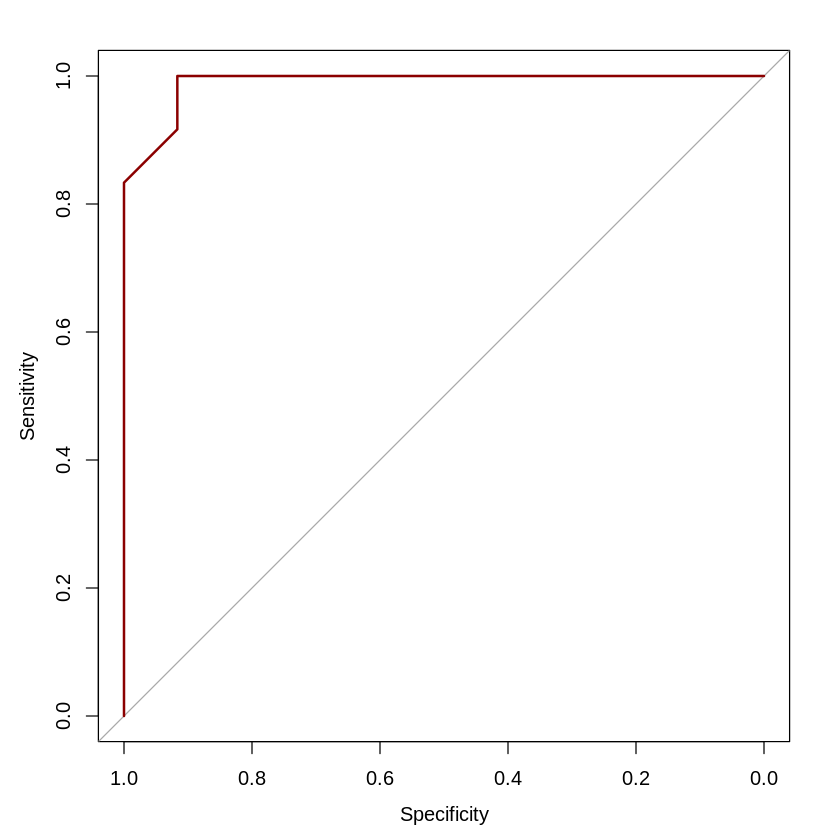

In [38]:
# plot ROC curve
plot(ROC_base, col = "darkred", main = NULL)
# print performance
paste("Accuracy: ", mean(test_y == round(prediction_probs_base[,2], digits = 0)))
paste("Area Under the Curve: ", AUC_base)

From the result above we can conclude that it's quite easy to predict the specie. Which features are the most important in the prediction? <br>

There are many ways to find out which features contribute the most to the predictive model. In the following, we will simply apply the inbuilt function in the caret package. Other useful packages for this purpose exist such as iml (https://cran.r-project.org/web/packages/iml/index.html) and SHAPforxgboost (https://cran.r-project.org/web/packages/SHAPforxgboost/readme/README.html). The SHAP analysis is also included in the xgboost package (see below for this analysis).



In [39]:
# function implemented in caret. The higher the value compared to another feature, the more important is the 
# feature that contributed to the prediction
var_imp_base <- varImp(xgb_base, scale = T) # use scale = T to scale to 100
var_imp_base

xgbTree variable importance

  only 20 most important variables shown (out of 2681)

                    Overall
1002_213.102_1.957  100.000
8724_906.826_6.332   70.120
8803_413.323_6.287   59.136
8117_1022.673_6.202  41.613
8130_1044.656_6.206   5.546
667_565.177_1.607     0.000
579_565.177_1.605     0.000
1149_273.157_2.141    0.000
6995_574.373_5.861    0.000
2963_168.066_3.171    0.000
4154_264.159_4.29     0.000
9260_490.87_6.545     0.000
1489_271.144_2.33     0.000
5962_453.167_5.429    0.000
10807_556.86_7.476    0.000
4726_294.117_4.908    0.000
4970_332.296_5.005    0.000
1069_223.106_2.14     0.000
1254_352.095_2.192    0.000
2508_269.15_2.884     0.000

As we can see, very few features are enough to drive the prediction.

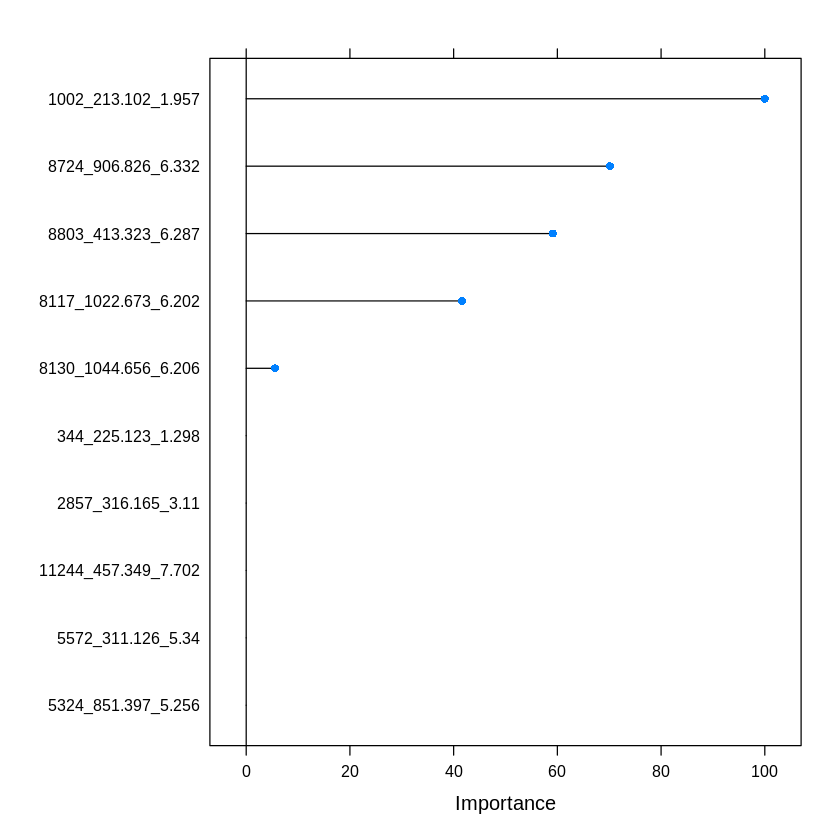

In [40]:
# you can also plot the importance
plot(var_imp_base, top = 10)

###<b>Let's predict the sample type now.</b>

In [41]:
# Split in train and test sets
# Set random seed to make results reproducible
set.seed(1234)
trainIndex_st <- caret::createDataPartition(df_ft$sample_class, p = 0.7, 
                                  list = FALSE, 
                                  times = 1)

ftTrain_st <- df_ft[trainIndex_st,]
ftTest_st  <- df_ft[-trainIndex_st,]

dim(ftTrain_st)
dim(ftTest_st)

[1]   56 2683

[1]   24 2683

In [42]:
# format inputs for the next steps
train_st_x <- ftTrain_st[,1:ncol(ft_mad)]
train_st_y <- as.factor(ftTrain_st$sample_class)
test_st_x <- ftTest_st[,1:ncol(ft_mad)]
test_st_y <- as.factor(ftTest_st$sample_class)

In [43]:
dim(train_st_x)
table(train_st_y)
dim(test_st_x)
table(test_st_y)

[1]   56 2681

train_st_y
 0  1 
14 42 

[1]   24 2681

test_st_y
 0  1 
 6 18 

In [44]:
# with default/recommended parameters for XGBoost
# perform the actual training
set.seed(1234)
xgb_base_st <- caret::train(
  x = train_st_x, y = train_st_y,
  trControl = train_control,
  tuneGrid = grid_default,
  method = "xgbTree",
  verbose = TRUE
)

In [45]:
xgb_base_st

eXtreme Gradient Boosting 

  56 samples
2681 predictors
   2 classes: '0', '1' 

No pre-processing
Resampling: None 

In [46]:
# We now predict on test data
predicted_base_st <- predict(xgb_base_st, test_st_x)
# evaluate performance
confusionMatrix(data = predicted_base_st, reference = test_st_y, positive = '1', mode = 'everything')

Confusion Matrix and Statistics

          Reference
Prediction  0  1
         0  5  1
         1  1 17
                                        
               Accuracy : 0.9167        
                 95% CI : (0.73, 0.9897)
    No Information Rate : 0.75          
    P-Value [Acc > NIR] : 0.0398        
                                        
                  Kappa : 0.7778        
                                        
 Mcnemar's Test P-Value : 1.0000        
                                        
            Sensitivity : 0.9444        
            Specificity : 0.8333        
         Pos Pred Value : 0.9444        
         Neg Pred Value : 0.8333        
              Precision : 0.9444        
                 Recall : 0.9444        
                     F1 : 0.9444        
             Prevalence : 0.7500        
         Detection Rate : 0.7083        
   Detection Prevalence : 0.7500        
      Balanced Accuracy : 0.8889        
                                   

In [47]:
# predict on test data (this time we keep the probabilities)
prediction_probs_base_st <- predict(xgb_base_st, test_st_x, type = "prob")
# ROC curve
ROC_base_st <- pROC::roc(test_st_y, prediction_probs_base_st[,2]) # for class 1 (i.e. With_Treatment)
# Area Under Curve (AUC)
AUC_base_st <- pROC::auc(ROC_base_st)

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "Accuracy:  0.916666666666667"

[1] "Area Under the Curve:  0.990740740740741"

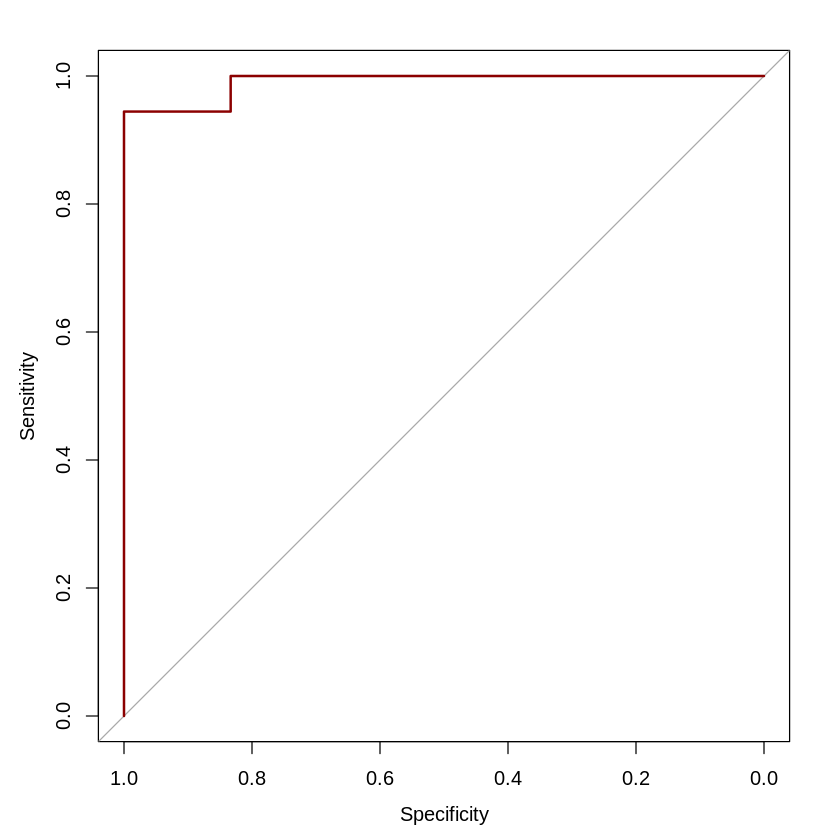

In [48]:
# plot ROC curve
plot(ROC_base_st, col = "darkred", main = NULL)
# print performance
paste("Accuracy: ", mean(test_st_y == round(prediction_probs_base_st[,2], digits = 0)))
paste("Area Under the Curve: ", AUC_base_st)

As we can see, in this "toy example" we can predict treatment vs control. Let's take a look at the most important features that are behind the prediction.

In [49]:
# function implemented in caret. The higher the value compared to another feature, the more important is the 
# feature that contributed to the prediction
var_imp_base_st <- varImp(xgb_base_st, scale = T) # use scale = T to scale to 100
var_imp_base_st

xgbTree variable importance

  only 20 most important variables shown (out of 2681)

                     Overall
3226_312.084_3.382  100.0000
3271_333.063_3.382   33.4722
2398_255.063_2.827    2.9891
234_195.113_0.891     0.4697
178_245.128_0.686     0.2825
265_190.086_0.968     0.2076
230_216.077_0.953     0.1821
97_245.095_0.521      0.1404
48_284.049_0.296      0.1382
679_378.156_1.615     0.0000
586_629.172_1.576     0.0000
1167_200.09_2.162     0.0000
7005_316.321_5.771    0.0000
2992_182.154_3.19     0.0000
4219_326.15_4.37      0.0000
9275_430.914_6.573    0.0000
1497_214.152_2.331    0.0000
6033_454.293_5.528    0.0000
10824_538.398_7.517   0.0000
4792_289.293_4.956    0.0000

###<b>Tuning parameters</b><br>

In the previous analyses, we obtained a very high performance since the difference between the two metabolic profiles for the two species and treatment vs control seem quite different. Usually, according to the difficulty of the specific task, you will need to tune the model's parameters in order to get good results and also to avoid [overfitting](https://www.ibm.com/cloud/learn/overfitting). <br>

There are many ways of tuning the parameters and it's a time consuming task. Therefore for the purpose of this notebook, we are not going to perform it but you are welcome to look at this notebook https://github.com/russof85/pred_alg/blob/main/xgboost_paramTuning_variableImp.ipynb or additional info to find some inspiration for your own analyses.

In [50]:
sessionInfo()

R version 4.2.0 (2022-04-22)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas/libblas.so.3
LAPACK: /usr/lib/x86_64-linux-gnu/libopenblasp-r0.2.20.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] pROC_1.18.0     dplyr_1.0.9     caret_6.0-92    lattice_0.20-45
[5] ggplot2_3.3.6   xgboost_1.6.0.1

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.9           lubridate_1.8.0      listenv_0.8.0       
 [4] class_7.3-20         assertthat_0.2.1     digest_